<a href="https://colab.research.google.com/github/tahaky/graduation-project/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Imports*

In [21]:
import numpy as np
import pandas as pd
from sklearn import preprocessing,metrics,manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import collections
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import RobustScaler
import xgboost
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('turkish')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Read csv file*

In [9]:

train_df = pd.read_csv('./data-set.csv', on_bad_lines='skip')
#Display the first few rows of the dataset
print(train_df.head())

#Summary statistics
print(train_df.describe())

#Information about the dataset
print(train_df.info())

print(train_df.duplicated().sum())

good_reviews=train_df[train_df['Durum']==1]['Metin']
bad_reviews=train_df[train_df['Durum']==2]['Metin']
notr_reviews=train_df[train_df['Durum']==0]['Metin']

print("First 10 samples of good reviews\n".format(),good_reviews[:10])
print("First 10 samples of bad reviews\n".format(),bad_reviews[:10])
print("First 10 samples of notr reviews\n".format(),notr_reviews[:10])




                                               Metin  Durum
0                              evet anlatıldığı gibi      1
1  Daha öncede almıştım bu cihazdan ense ve sakal...      1
2  Ürün gayet başarılı sakal kesmede başlık sayıs...      1
3  Daha öncede aynısını almıştım çok güzel ve kal...      1
4  Erkek kuaförüyüm ense ve sıfır sakal traşı içi...      1
              Durum
count  13725.000000
mean       0.626011
std        0.640908
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        2.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13725 entries, 0 to 13724
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Metin   13725 non-null  object
 1   Durum   13725 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 214.6+ KB
None
1485
First 10 samples of good reviews
 0                                 evet anlatıldığı gibi
1     Daha öncede almıştım bu cihazdan ense ve sakal...


Total Counts of both sets Metin
Güzel bir ürün                                                                                                                                                                                                                                                                                                                                                                                             18
idare eder                                                                                                                                                                                                                                                                                                                                                                                                 17
İdare eder                                                                                                                                                                  

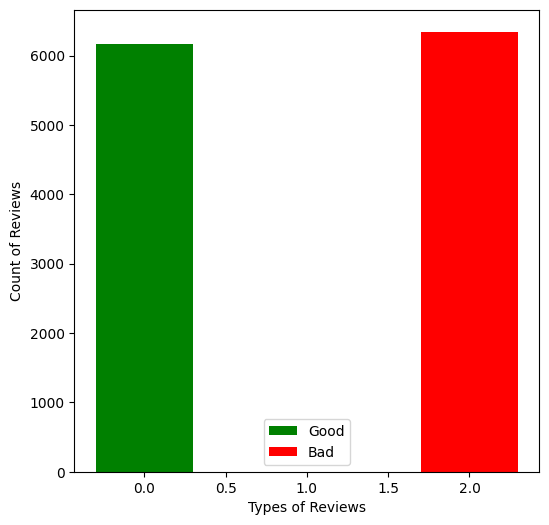

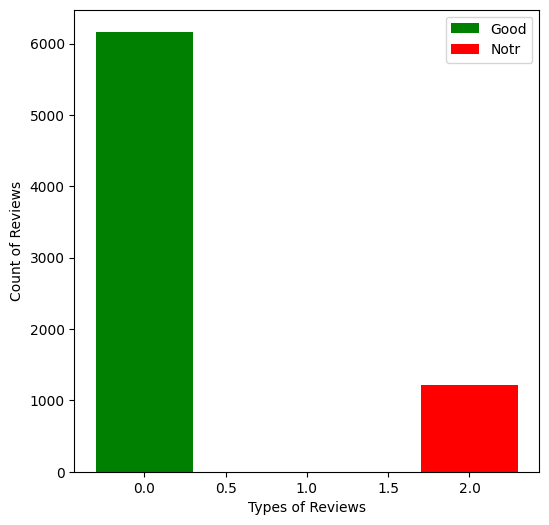

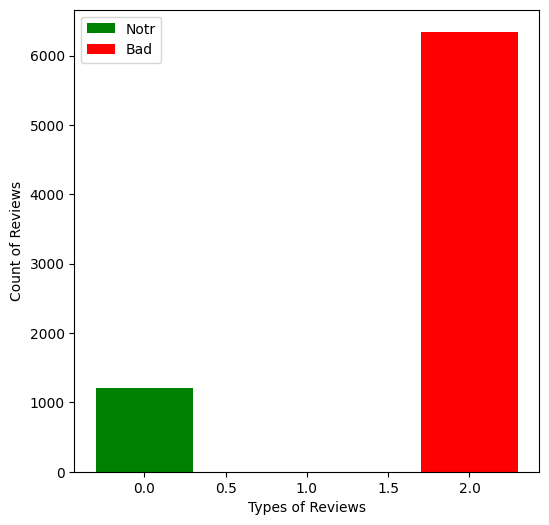

In [11]:
#Count of good and bad reviews
count=train_df['Metin'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad,sl_name,sr_name):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label=sl_name,color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label=sr_name,color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()

count_good=train_df[train_df['Durum']==1]
count_bad=train_df[train_df['Durum']==0]
count_notr=train_df[train_df['Durum']==2]

plot_counts(len(count_good),len(count_bad),"Good","Bad")
plot_counts(len(count_good),len(count_notr),"Good","Notr")
plot_counts(len(count_notr),len(count_bad),"Notr","Bad")


Positive Review Words:0         3
1        15
2        24
3        10
4        11
         ..
13388     3
13392     5
13408     3
13665     2
13672     4
Name: Metin, Length: 6168, dtype: int64
Negative Review Words:9        27
12        4
25       14
40        5
41       22
         ..
13720     3
13721    10
13722     6
13723    10
13724     6
Name: Metin, Length: 6345, dtype: int64
Notr Review Words:15        3
33       18
56        5
65        9
68        9
         ..
13395     2
13417     4
13424     6
13565    21
13569    17
Name: Metin, Length: 1212, dtype: int64


<ipython-input-12-ac3159ff9c19>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-12-ac3159ff9c19>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




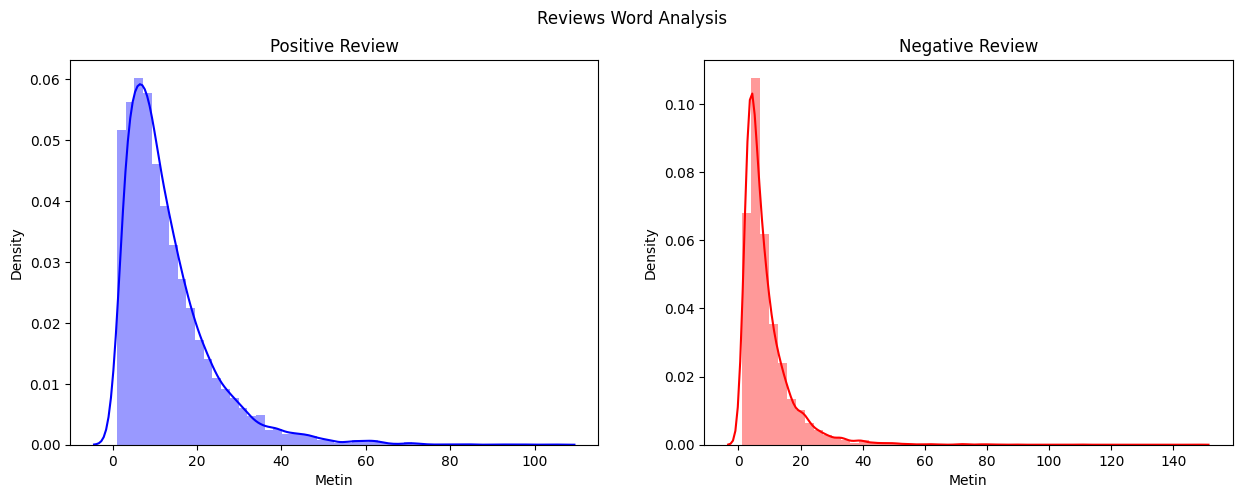

<ipython-input-12-ac3159ff9c19>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-12-ac3159ff9c19>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




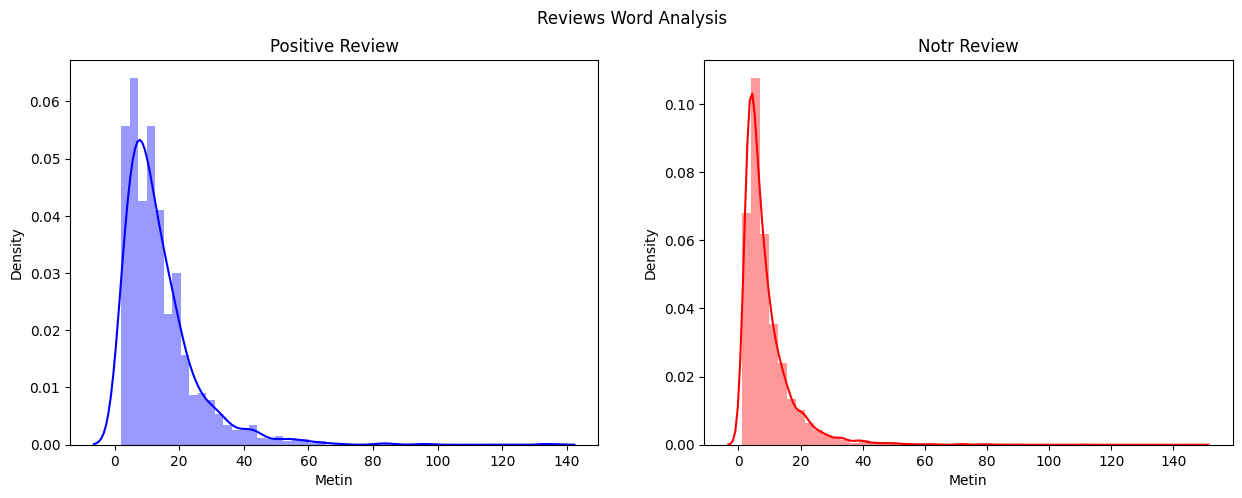

<ipython-input-12-ac3159ff9c19>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-12-ac3159ff9c19>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




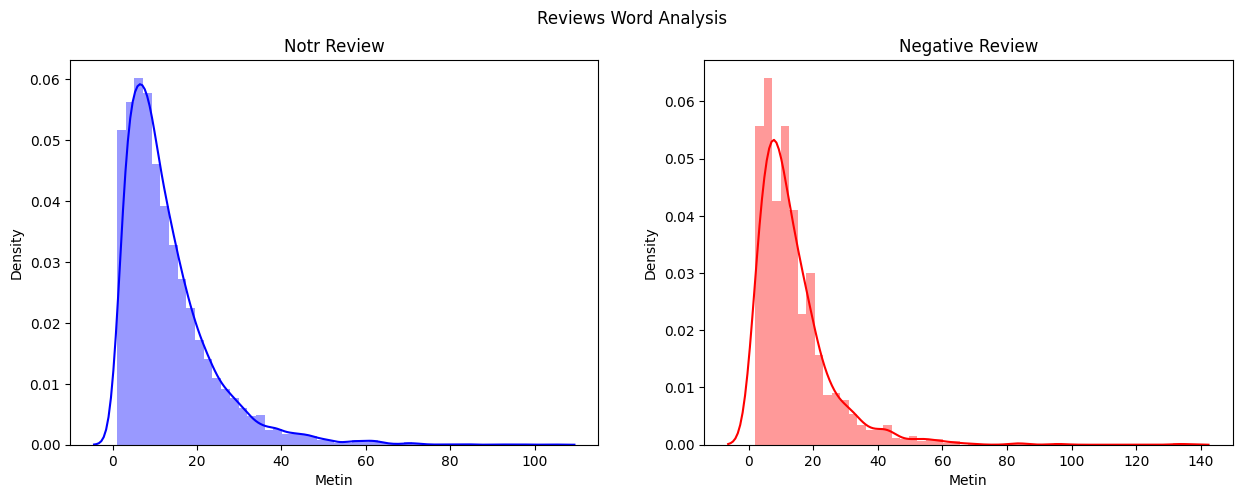

In [12]:
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()




count_good_words=count_good['Metin'].str.split().apply(lambda z:cal_len(z))
count_bad_words=count_bad['Metin'].str.split().apply(lambda z:cal_len(z))
count_notr_words=count_notr['Metin'].str.split().apply(lambda z:cal_len(z))

print("Positive Review Words:" + str(count_good_words))
print("Negative Review Words:" + str(count_bad_words))
print("Notr Review Words:" + str(count_notr_words))

plot_count(count_good_words,count_bad_words,"Positive Review","Negative Review","Reviews Word Analysis")
plot_count(count_good_words,count_notr_words,"Positive Review","Notr Review","Reviews Word Analysis")
plot_count(count_notr_words,count_bad_words,"Notr Review","Negative Review","Reviews Word Analysis")


<ipython-input-74-62ef7c0aa418>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-74-62ef7c0aa418>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




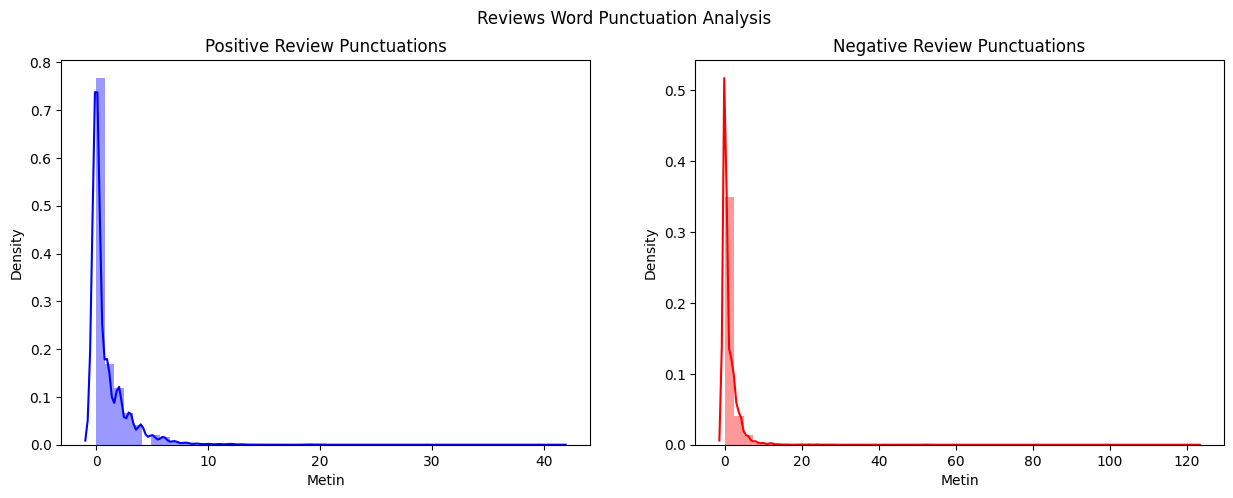

<ipython-input-74-62ef7c0aa418>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-74-62ef7c0aa418>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




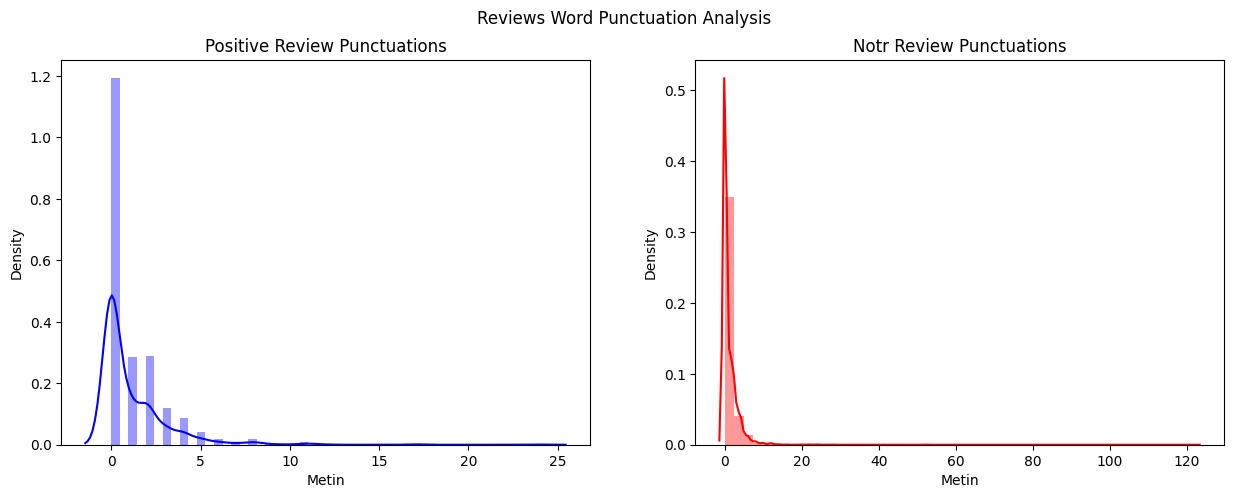

<ipython-input-74-62ef7c0aa418>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-74-62ef7c0aa418>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




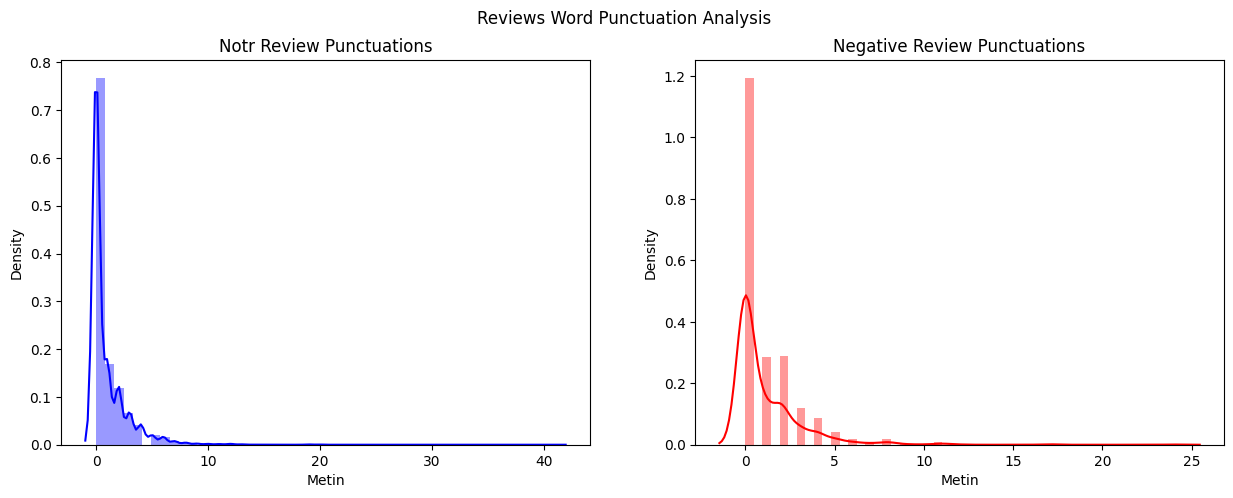

In [ ]:
#Count Punctuations/Stopwords/Codes and other semantic datatypes
#We will be using the "generic_plotter" function.

count_good_punctuations=count_good['Metin'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_bad_punctuations=count_bad['Metin'].apply(lambda z:len([c for c in str(z) if c in string.punctuation]))
count_notr_punctuations=count_notr['Metin'].apply(lambda z:len([c for c in str(z) if c in string.punctuation]))

plot_count(count_good_punctuations,count_bad_punctuations,"Positive Review Punctuations","Negative Review Punctuations","Reviews Word Punctuation Analysis")
plot_count(count_good_punctuations,count_notr_punctuations,"Positive Review Punctuations","Notr Review Punctuations","Reviews Word Punctuation Analysis")
plot_count(count_notr_punctuations,count_bad_punctuations,"Notr Review Punctuations","Negative Review Punctuations","Reviews Word Punctuation Analysis")

<ipython-input-13-d38da0e774c3>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-13-d38da0e774c3>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




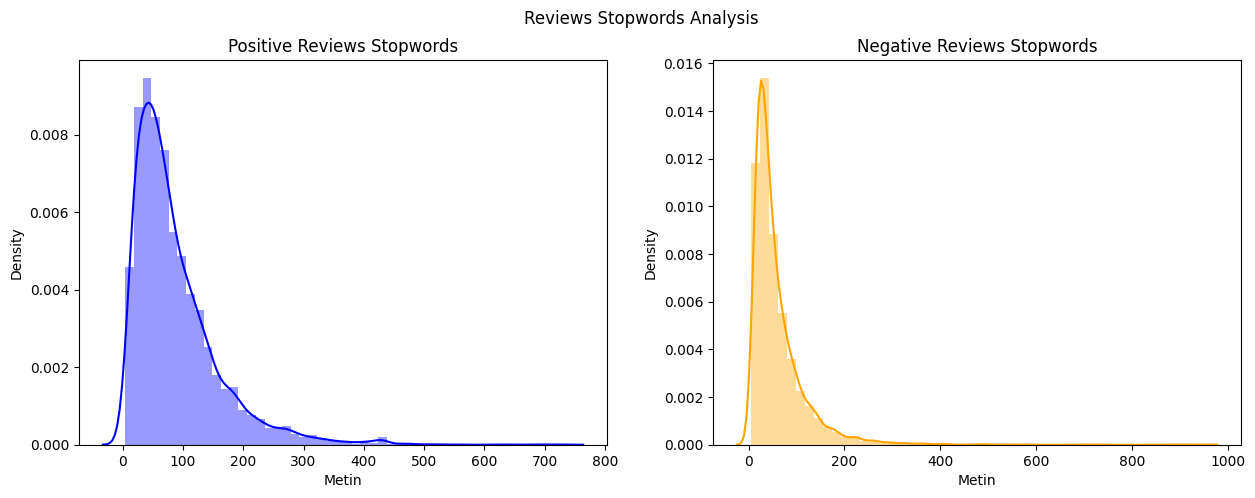

<ipython-input-13-d38da0e774c3>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-13-d38da0e774c3>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




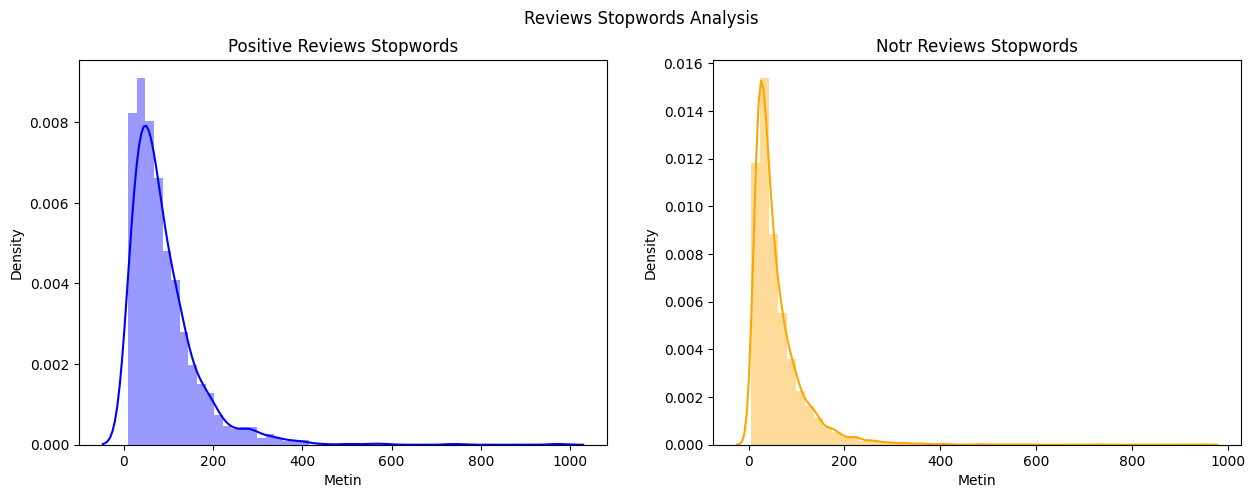

<ipython-input-13-d38da0e774c3>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-13-d38da0e774c3>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




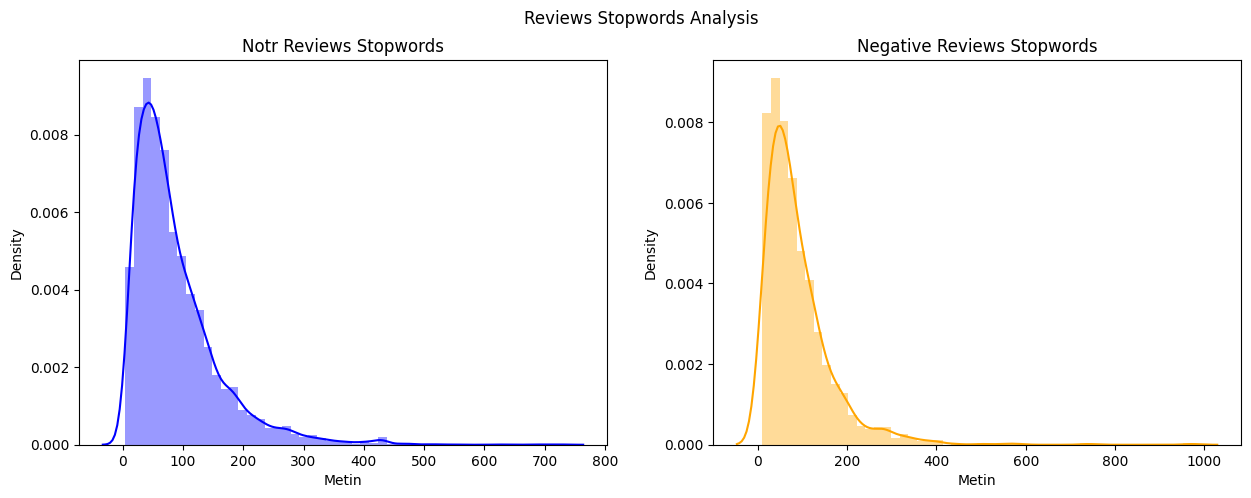

In [13]:
#Analyse Stopwords

def plot_count_1(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Orange')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()


stops=set(stopwords.words('turkish'))
count_good_stops=count_good['Metin'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_bad_stops=count_bad['Metin'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_notr_stops=count_notr['Metin'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))

plot_count_1(count_good_stops,count_bad_stops,"Positive Reviews Stopwords","Negative Reviews Stopwords","Reviews Stopwords Analysis")
plot_count_1(count_good_stops,count_notr_stops,"Positive Reviews Stopwords","Notr Reviews Stopwords","Reviews Stopwords Analysis")
plot_count_1(count_notr_stops,count_bad_stops,"Notr Reviews Stopwords","Negative Reviews Stopwords","Reviews Stopwords Analysis")

<Axes: >

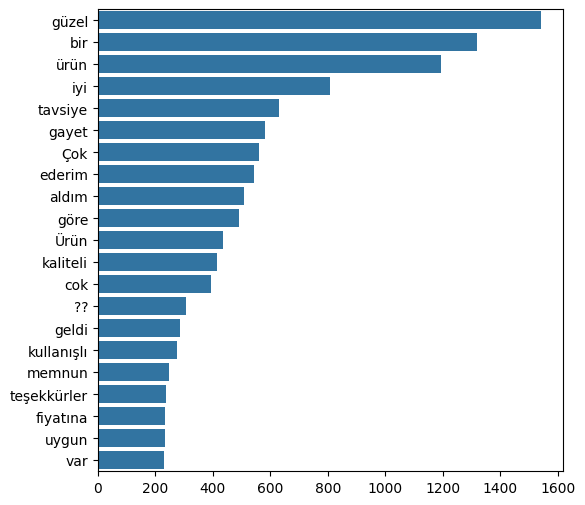

In [ ]:
#Simplified counter function
def create_corpus(word):
    corpus=[]

    for x in train_df[train_df['Durum']==word]['Metin'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus(1)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:30]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

In [22]:
#Gram analysis on Training set- Bigram and Trigram
stopword=set(stopwords.words('turkish'))
def gram_analysis(data,gram):
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stopword]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens


#Create frequency grams for analysis

def create_dict(data,grams):
    freq_dict=defaultdict(int)
    for sentence in data:
        for tokens in gram_analysis(sentence,grams):
            freq_dict[tokens]+=1
    return freq_dict

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["n_gram_words"].values[::-1],
        x=df["n_gram_frequency"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace



def create_new_df(freq_dict,):
    freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns=['n_gram_words','n_gram_frequency']
    #print(freq_df.head())
    #plt.barh(freq_df['n_gram_words'][:20],freq_df['n_gram_frequency'][:20],linewidth=0.3)
    #plt.show()
    trace=horizontal_bar_chart(freq_df[:20],'orange')
    return trace

def plot_grams(trace_zero,trace_one):
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews",
                                          "Frequent words of negative reviews"])
    fig.append_trace(trace_zero, 1, 1)
    fig.append_trace(trace_ones, 1, 2)
    fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')


train_df_zero=count_bad['Metin']
train_df_ones=count_good['Metin']

print("Bi-gram analysis")
freq_train_df_zero=create_dict(train_df_zero[:200],2)
#print(freq_train_df_zero)
trace_zero=create_new_df(freq_train_df_zero)
freq_train_df_ones=create_dict(train_df_ones[:200],2)
#print(freq_train_df_zero)
trace_ones=create_new_df(freq_train_df_ones)
plot_grams(trace_zero,trace_ones)
print("Tri-gram analysis")
freq_train_df_zero=create_dict(train_df_zero[:200],3)
#print(freq_train_df_zero)
trace_zero=create_new_df(freq_train_df_zero)
freq_train_df_ones=create_dict(train_df_ones[:200],3)
#print(freq_train_df_zero)
trace_ones=create_new_df(freq_train_df_ones)
plot_grams(trace_zero,trace_ones)

Bi-gram analysis


Tri-gram analysis
